In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("data/processed/processed_v1.csv", low_memory=False)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [6]:
X = df.drop('Sales Price', axis=1)
y = df['Sales Price']


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42 
)

print(f"Original shape: {X.shape}")
print(f"Train shape:    {X_train.shape}")
print(f"Validate shape: {X_val.shape}")
print(f"Test shape:     {X_test.shape}")

Original shape: (412698, 44)
Train shape:    (315713, 44)
Validate shape: (55715, 44)
Test shape:     (41270, 44)


In [ ]:
def objective(trial):
    
    params = {
        'objective': 'regression_l1',
        'metric': 'l1', 
        'n_estimators': 6000,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l1',
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )

    # save the best iteration
    trial.set_user_attr('best_iteration', model.best_iteration_)

    log_preds = model.predict(X_val)
    final_y_val = np.expm1(y_val)
    final_preds = np.expm1(log_preds)
    dollar_mae = mean_absolute_error(final_y_val, final_preds)
    
    # on trial 1 and 2, plot the l1 losses
    if trial.number in [1, 2]:
        l1_values = model.evals_result_['valid_0']['l1']
        plt.figure(figsize=(10, 5))
        plt.plot(l1_values)
        plt.title(f'Trial {trial.number} - Validation L1 Loss over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('L1 Loss')
        plt.grid()
        plt.show()

    return dollar_mae

study = optuna.create_study(direction='minimize')
study.optimize(
    objective, 
    n_trials=50, 
    show_progress_bar=True
)
print(f"Best Validation MAE: ${study.best_trial.value:,.2f}")

[I 2025-10-28 22:48:23,517] A new study created in memory with name: no-name-93b2f8c3-3e3c-44a1-90ba-8c68133cd59d
  0%|          | 0/50 [00:04<?, ?it/s]


[W 2025-10-28 22:48:27,863] Trial 0 failed with parameters: {'learning_rate': 0.017844529665331097, 'num_leaves': 150, 'max_depth': 49, 'subsample': 0.6552151036432644, 'colsample_bytree': 0.8838588863218664} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/lukaszsawala/Programming/Personal-projects/Bit-project/bit-intro-assignment/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/pj/kpd4vj4j6_b_l77b3ry75hp40000gn/T/ipykernel_58575/3603600185.py", line 19, in objective
    model.fit(
  File "/Users/lukaszsawala/Programming/Personal-projects/Bit-project/bit-intro-assignment/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1398, in fit
    super().fit(
  File "/Users/lukaszsawala/Programming/Personal-projects/Bit-project/bit-intro-assignment/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", 

KeyboardInterrupt: 

In [8]:
best_params = {'learning_rate': 0.04540528520736908, 'num_leaves': 300, 'max_depth': 28, 'subsample': 0.7315293466674355, 'colsample_bytree': 0.6846844766027065}
best_iteration = int(4224.303934824201)


## Evaluation

In [ ]:
#best_params = study.best_trial.params
#best_iteration = study.best_trial.user_attrs['best_iteration']

#print(f"Best iteration found: {best_iteration}")
print("Best parameters:")
for key, value in best_params.items():
    print(f"    {key}: {value}")


final_model = lgb.LGBMRegressor(
    objective='regression_l1',
    metric='l1',
    random_state=42,
    n_jobs=-1,
    **best_params,
    n_estimators=best_iteration
)

# Train on the full (Train + Val) dataset
final_model.fit(X_train_val, y_train_val)
print("Succesfully fit the model!")

Best parameters:
    learning_rate: 0.04540528520736908
    num_leaves: 300
    max_depth: 28
    subsample: 0.7315293466674355
    colsample_bytree: 0.6846844766027065
Evaluating on unseen Test data...
Final Test MAE (Unbiased): $4,196.63


In [ ]:
final_log_preds = final_model.predict(X_test) # make the final predictions

final_y_test = np.expm1(y_test)
final_preds = np.expm1(final_log_preds)

final_dollar_mae = mean_absolute_error(final_y_test, final_preds)

In [ ]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

log_preds = final_model.predict(X_train_val)
final_train_val_y = np.expm1(y_train_val)
final_preds = np.expm1(log_preds)

# Calculate Mean Absolute Error on the real prices
dollar_mae = mean_absolute_error(final_train_val_y, final_preds)

print(f"MAE for the Train-Val set: ${dollar_mae:,.2f} in % of the price: {100 * dollar_mae / final_train_val_y.mean():.2f}%")
print(f"Final Test MAE (Unbiased): ${final_dollar_mae:,.2f} in % of the price: {100 * final_dollar_mae / final_y_test.mean():.2f}%")
# lgb.plot_metric(final_model, metric='l1')
# plt.title('LightGBM Training Loss Curve')
# plt.xlabel('Training Rounds (Iterations)')
# plt.ylabel('l1 (MAE)')

Mean Absolute Error (in Dollars): $3,170.10 in % of the price: 10.15%


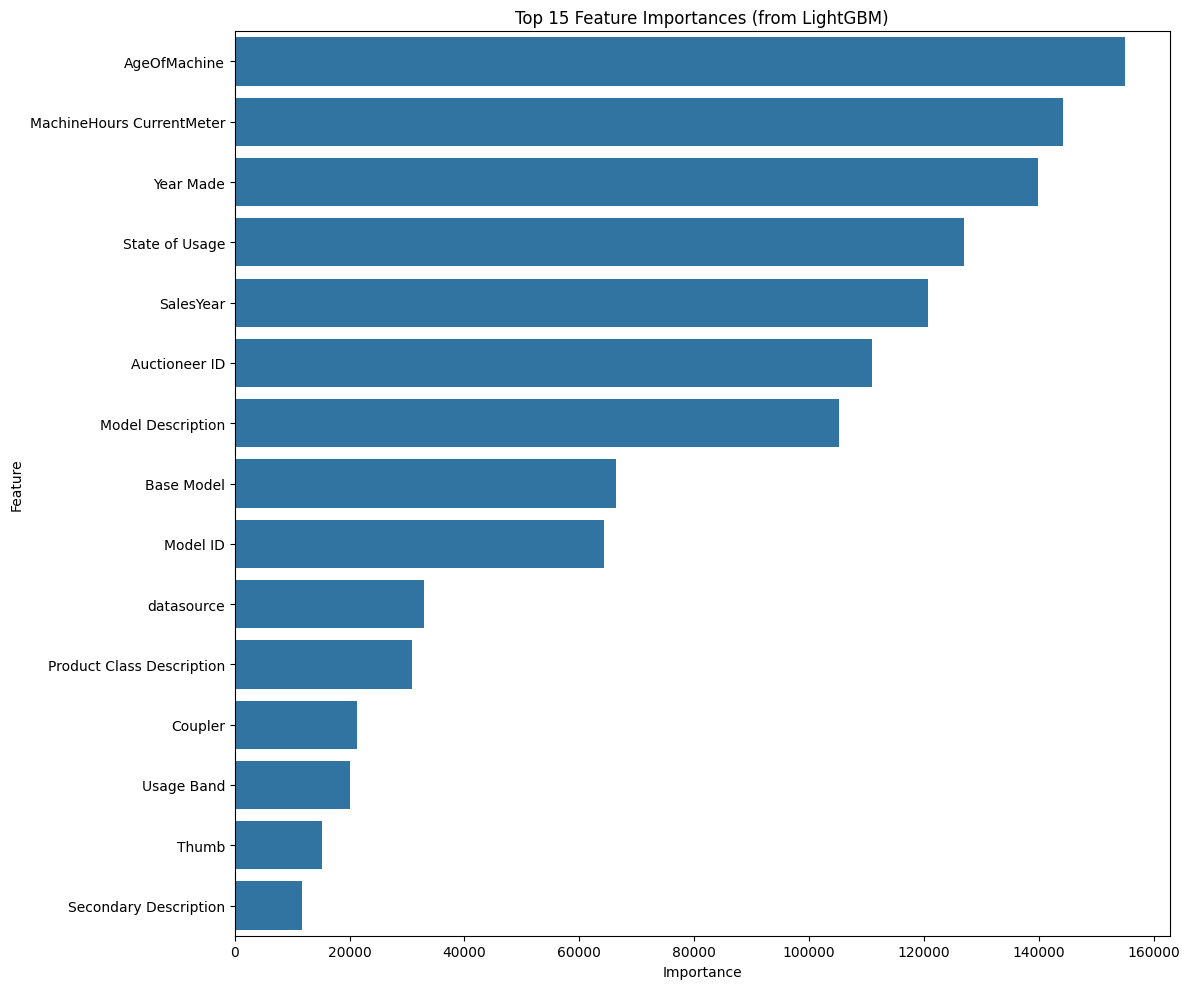

In [7]:
import seaborn as sns
# Get feature importances
importances = final_model.feature_importances_
feature_names = X_train_val.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df.head(15) 
)
plt.title('Top 15 Feature Importances (from LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# for later use with python scripts

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import wandb


wandb.init(project="lgbm-price-prediction", name="optuna-study-2", reinit=True)

def objective(trial):
    # Define parameter space
    params_to_tune = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    model = lgb.LGBMRegressor(
        objective='regression_l1',
        metric='mae',
        n_estimators=5000,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        **params_to_tune
    )

    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )

    # Evaluate model
    log_preds = model.predict(X_val)
    final_mae = mean_absolute_error(np.expm1(y_val), np.expm1(log_preds))

    # --- Log each trial’s results as a row in a single table ---
    wandb.log({
        "trial_number": trial.number,
        "final_mae": final_mae,
        **params_to_tune
    })

    return final_mae


# --- Run the Optuna study ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# --- Log best result summary ---
wandb.summary["best_trial"] = study.best_trial.number
wandb.summary["best_mae"] = study.best_value
wandb.summary.update(study.best_trial.params)

wandb.finish()